# Pytta notebook demonstration

We will perform some measurements using the Pytta package (https://pytta.readthedocs.io/pyttadoc/index.html)

Pytta is an open-source code for measurements, recordings, and signal analysis. It is based on the ITA-toolbox for Matlab from RWTH University (https://www.ita-toolbox.org/)

In [1]:
import pytta
#import PyTTa.pytta
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 11})
#%matplotlib notebook
#%matplotlib widget

In [2]:
pytta.__file__

'C:\\Users\\Cliente\\anaconda3\\envs\\pytta_test\\Lib\\site-packages\\pytta\\__init__.py'

# List devices

The first thing we will do is to choose which audio device we want to use to measure. 

Pytta supports the Audio devices listed with Port Audio. Note that devices such as BK or NI data acquisition are not audio interfaces and, therefore, are not natively supported by Pytta. However, when measuring with such devices, one can use Pytta as a data container for signal processing.

Let us choose the input and output devices with a particular driver. The best is the proprietary ASIO driver for each audio device, usually the driver with the smallest latency. For Impulse Response (IR) estimation, if synchronization between recording and excitation is strictly necessary you should record the excitation signal, $x(t)$. The output, $y(t)$, should always be measured.

In [2]:
print(pytta.list_devices())

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Analogue 1 + 2 (Focusrite USB A, MME (2 in, 0 out)
   2 Microfone (Realtek(R) Audio), MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Alto-falantes (Focusrite USB Au, MME (0 in, 2 out)
   5 Speakers/Headphones (Realtek(R), MME (0 in, 2 out)
   6 Acer KG271 (NVIDIA High Definit, MME (0 in, 2 out)
   7 Driver de captura de som primário, Windows DirectSound (2 in, 0 out)
   8 Analogue 1 + 2 (Focusrite USB Audio), Windows DirectSound (2 in, 0 out)
   9 Microfone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Driver de som primário, Windows DirectSound (0 in, 2 out)
  11 Alto-falantes (Focusrite USB Audio), Windows DirectSound (0 in, 2 out)
  12 Speakers/Headphones (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  13 Acer KG271 (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  14 ASIO4ALL v2, ASIO (2 in, 8 out)
  15 Focusrite USB ASIO, ASIO (6 in, 6 out)
  16 Realte

In [3]:
device = 15#[7, 10]

# Configure the measurement

We need to define some basic properties:

 - fs: (int) : the sampling rate supported by your audio interface.
 - start_margin / stop_margin: (float): Your excitation signal, $x(t)$, can have a small silence at its start and end. The silence at its end is essential to ensure that the system's natural decay is recorded.
 - fft_degree: (int) - if this is specified, the excitation and recorded signals will have $2^{\text{fft_degree}}$ samples. The time vector of the signal will be between $0$ [s] $(2^{\text{fft_degree}}-1)/fs$ [s]. You can also specify the time duration of the signals (then, fft_degree will be computed for you).

In [6]:
fs = 44100 # sample rate of your audio device
start_margin = 0.1
stop_margin = 0.5
fft_degree = 18 # N_samples = 2**fft_degree

# Excitation signal - Sweep

Let us generate the excitation signal with Pytta. This signal will be a logarithmic sine sweep, but other options are available. We define a start frequency and an end frequency. 

When measuring, try to consider the characteristics of your sound source. There is no point in asking a source to generate frequencies outside the range in which it is efficient.

In [7]:
freq_min = 100
freq_max = 10000
method = 'logarithmic'

xt = pytta.generate.sweep(freqMin = freq_min, freqMax = freq_max, samplingRate = fs, fftDegree = fft_degree, 
                          startMargin = start_margin, stopMargin = stop_margin, method = method, windowing='hann')

# Visualize and listen to $x(t)$

Note that the excitation signal sweep has a fade-in, a fade-out, and a small silence at the beginning and end. This serves as a buffer in your measurement, so you do not send some step function to your sound source.

Note that the $x(t)$ spectrum has relevant components before **freq_min** and after **freq_max**. The programming so that the sweep amplitude is $1.0$ between **freq_min** and **freq_max** (in time dommain). Thus, the fade-in and fade-out place a few extra relevant components.

Note also that the magnitude of the $x(t)$ spectrum has minimum values in the order of $-125$ dB, $-200$ dB, which is equivalent to numbers in the order of:

- $10^{-7}$, $10^{-10}$ 

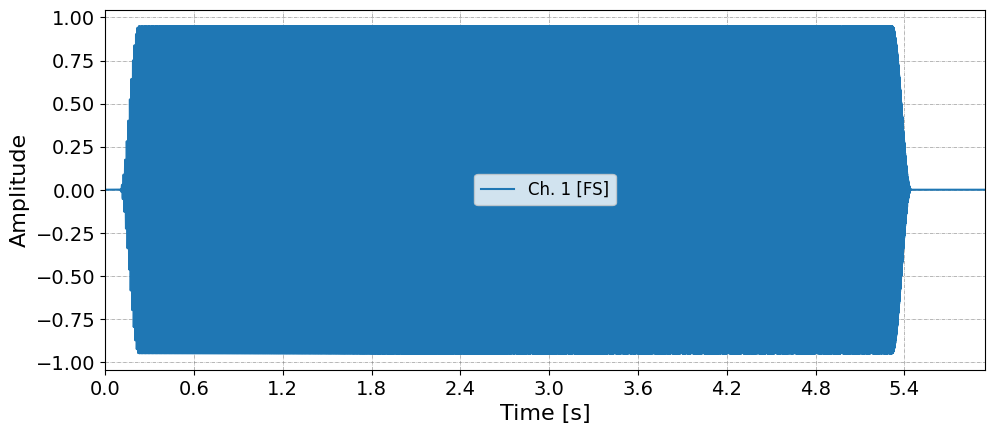

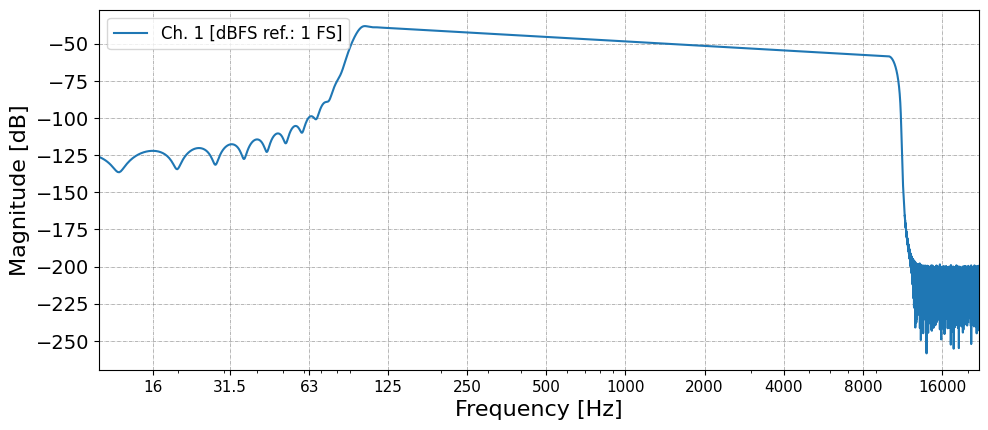

In [8]:
xt.plot_time(decimalSep = '.');
xt.plot_freq(xLim = [10, fs/2], decimalSep = '.');

In [9]:
xt.play(device = 15) #device = 11

# SignalObj

Inside Pytta, information about a signal stays inside a signal object (SignalObj). With such information, we can plot the $x(t)$ spectrum.

In [11]:
xt

SignalObj(SignalArray=ndarray, domain='time', samplingRate=44100, freqMin=89.08987181403393, freqMax=11224.62048309373, comment='No comments.')

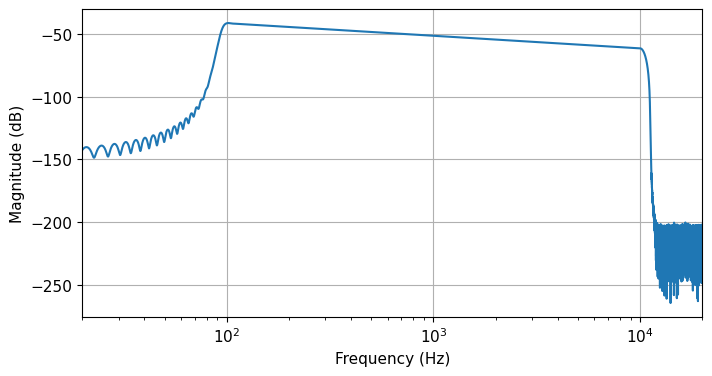

In [12]:
plt.figure(figsize = (8, 4))
plt.semilogx(xt.freqVector, 20*np.log10(np.abs(xt.freqSignal)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim((20, 20000))
plt.grid()

In [13]:
print('fft_degree: {} / number of samples: {}'.format(fft_degree, 2**fft_degree))
print('Shape of time dommain data: {} - shape changes if your signal obj has more channels'.format(xt.timeSignal.shape))
print('Shape of frequency dommain data: {}'.format(xt.freqSignal.shape))

fft_degree: 19 / number of samples: 524288
Shape of time dommain data: (524288, 1) - shape changes if your signal obj has more channels
Shape of frequency dommain data: (262145, 1)


# Generate a measurement object

Now, we generate a Pytta object that controls the measurement. We will work on a **'playrec'** object that performs playback and record simultaneously. You need to select the input and output channels. Pytta supports as many channels as you have in your audio interface.

There are other measurement object types, so check the documentation.

In [10]:
pytta_meas = pytta.generate.measurement('playrec', excitation = xt, samplingRate = xt.samplingRate,
                                        freqMin = freq_min, freqMax = freq_max,
                                        device = device, inChannels=[1], outChannels=[1])

# Execute the measurement

Now, we measure. Note that $x(t)$ is not contaminated by noise, but $y(t)$ is, which can be written in the form

\begin{equation}
y_m(t) = y(t) + n(t)
\end{equation}
where the measured signal, $y_m(t)$ is the sum of the true value $y(t)$ plus a noise term $n(t)$.

In [11]:
yt = pytta_meas.run()

max output level (excitation) on channel [1]: -0.45 dBFS - ref.: 1 [FS]
max input level (excitation) on channel [1]: -36.84 dBFS - ref.: 1 [FS]


# Visualize and listen to $y(t)$

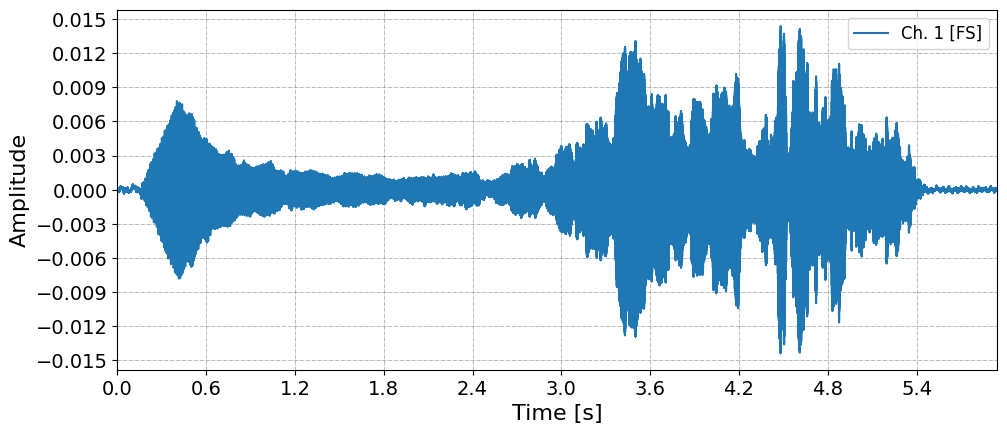

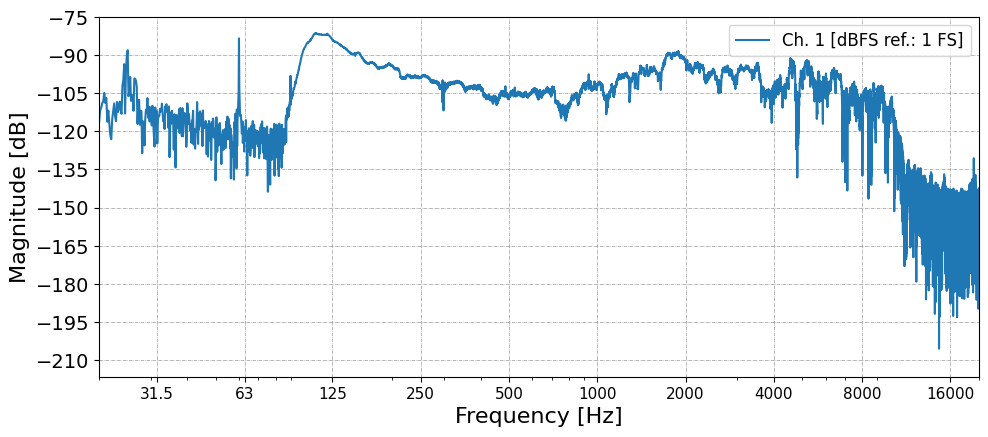

In [12]:
yt.plot_time(decimalSep = '.');
yt.plot_freq(xLim = [20, 20000], decimalSep = '.');

In [25]:
yt.play()

# You can save your measurement and load it for analysis

In [14]:
pytta.save('yt.hdf5', yt)
pytta.save('xt.hdf5', xt)

Saved inside the hdf5 file 1 PyTTa object of 1 object provided.
Saved inside the hdf5 file 1 PyTTa object of 1 object provided.


# Loading Pytta objects

In [9]:
xt_dict = pytta.load('xt.hdf5')
xt = xt_dict[list(xt_dict.keys())[0]] # this is a signal object

yt_dict = pytta.load('yt.hdf5')
yt = yt_dict[list(yt_dict.keys())[0]] # this is a signal object

Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.
Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.


# Splitting

We should split the recording if more than one channel was recorded (e.g., reference channel).

In [13]:
yt_split = yt.split()
yt_split

[SignalObj(SignalArray=ndarray, domain='time', samplingRate=44100, freqMin=89.08987181403393, freqMax=11224.62048309373, comment='SignalObj from a PlayRec measurement')]

# Let us compute the impulse response

First, we can try the naive solution.

\begin{equation}
H(\text{j}\omega) = \frac{Y_m(\text{j}\omega)}{X(\text{j}\omega)} = \frac{Y(\text{j}\omega)+N(\text{j}\omega)}{X(\text{j}\omega)} = H(\text{j}\omega) + \frac{N(\text{j}\omega)}{X(\text{j}\omega)}
\end{equation}

### Spoiler alert

That is very disappointing as noise dominates $y(t)$. 

In [23]:
ht_noreg = pytta.ImpulsiveResponse(excitation = xt, recording = yt_split[0], 
                                   samplingRate = xt.samplingRate, regularization = False)

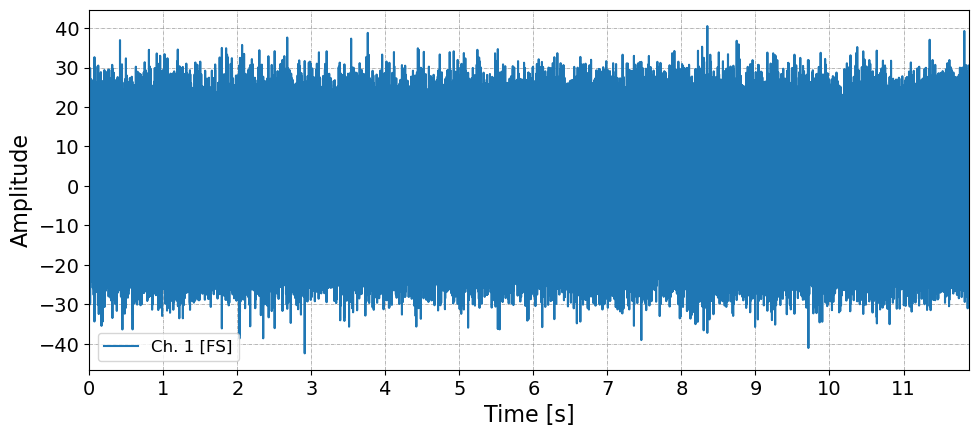

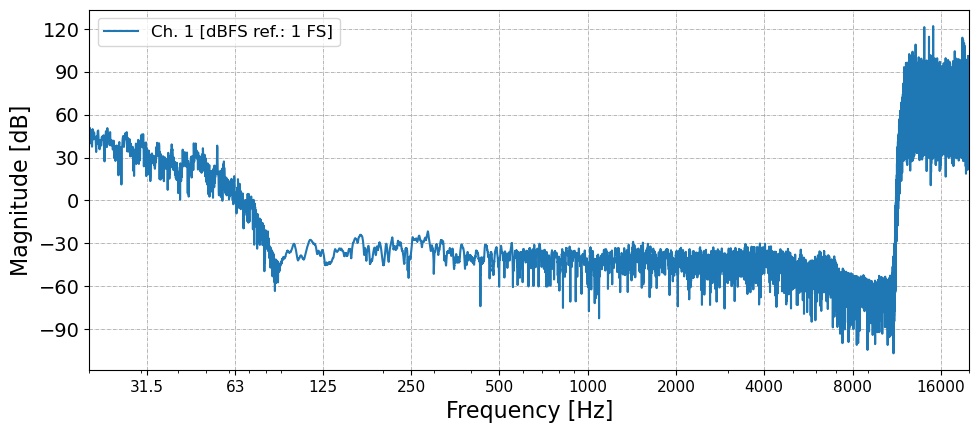

In [24]:
ht_noreg.plot_time(decimalSep = '.');
ht_noreg.plot_freq(xLim = [20, 20000], decimalSep = '.');

# We can do better

The idea is to change how we compute the FRF and the associated IR. Consider the following:

\begin{equation}
H(\text{j}\omega) = Y_m(\text{j}\omega) C(\text{j}\omega)
\end{equation}
with $C(\text{j}\omega)$ given by

\begin{equation}
C(\text{j}\omega) = \frac{X^{*}(\text{j}\omega)}{X^{*}(\text{j}\omega)X(\text{j}\omega)+\epsilon(\text{j}\omega)}
\end{equation}
and $\epsilon(\text{j}\omega)$ is a regularizing function [so we don't devide $Y_m(\text{j}\omega)$ by low magnitude values of $X(\text{j}\omega)$]. If $\epsilon(\text{j}\omega) = 0$, then $H(\text{j}\omega) = Y_m(\text{j}\omega) C(\text{j}\omega)$ is the naive solution, which only happens inside the **freq_min** and **freq_max limits**. Here is how $\epsilon(\text{j}\omega)$ looks like:

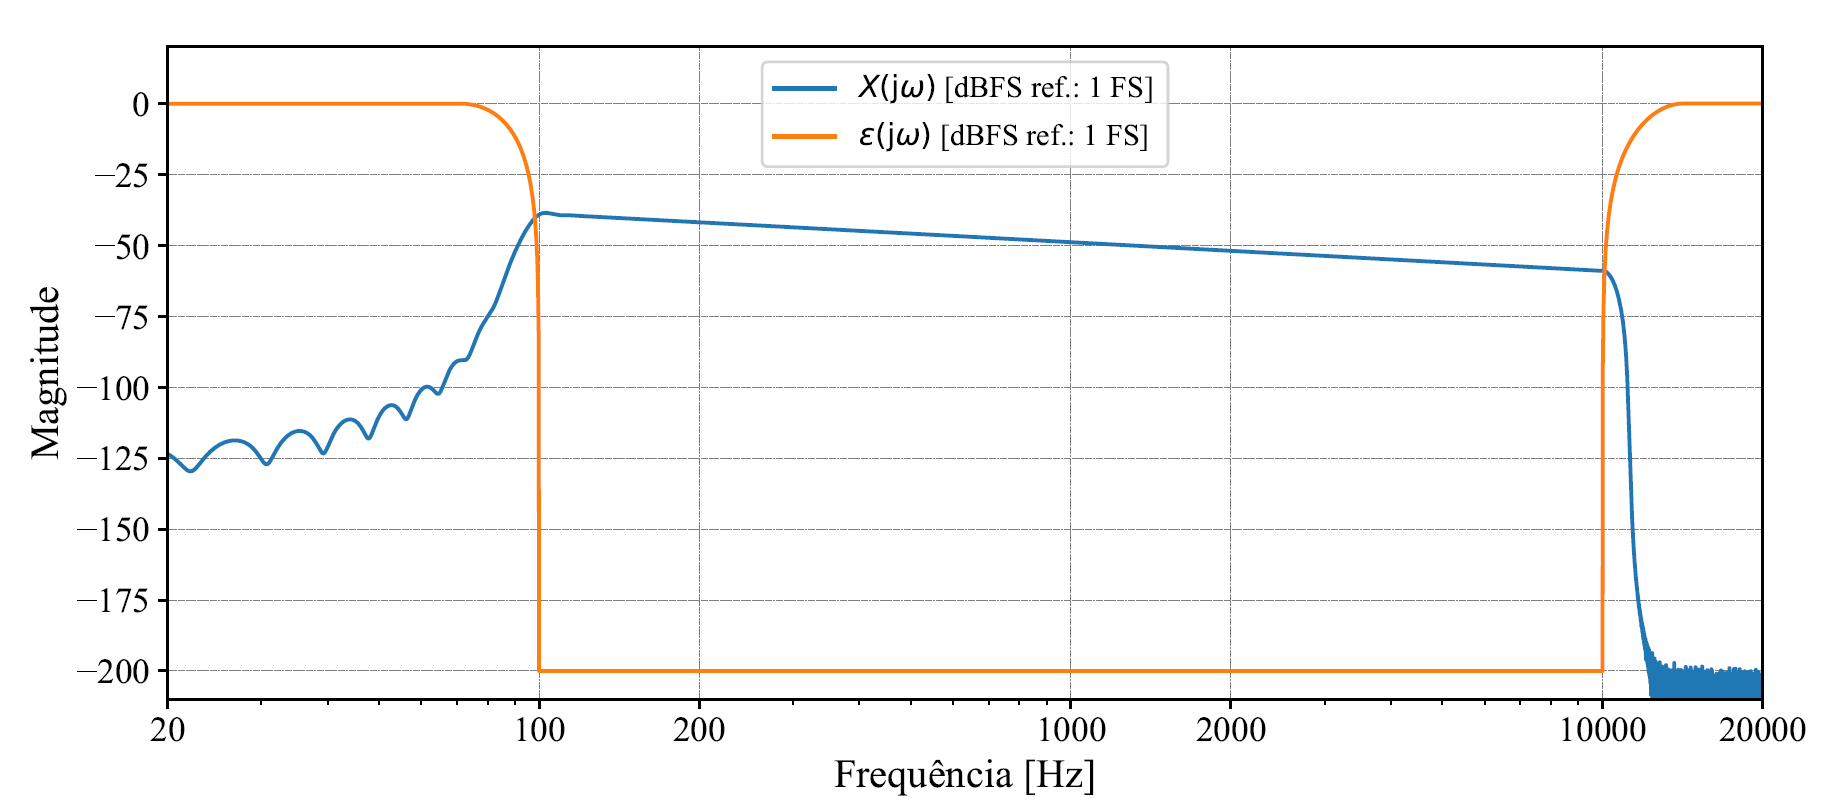

- In the frequency range where $X(\text{j}\omega)$ has a high magnitude, $\epsilon(\text{j}\omega)$ has a minimum magnitude (in the order of the computer's numerical precision). In this case $C(\text{j}\omega) \approx \frac{1}{X(\text{j}\omega)}$.

- In the frequency range where $X(\text{j}\omega)$ has low magnitude and noise tends to dominate, $\epsilon(\text{j}\omega)$ has maximum magnitude. In this case $C(\text{j}\omega) \approx \frac{1}{\epsilon(\text{j}\omega)}$ and the noise term is restricted to $\approx N(\text{j}\omega)/\epsilon(\text{j}\omega)$. In this range $Y(\text{j}\omega) \rightarrow 0$.


In [14]:
ht = pytta.ImpulsiveResponse(excitation = xt, recording = yt_split[0], 
                             samplingRate = xt.samplingRate, regularization = True,
                             freq_limits = [freq_min, freq_max], method = 'linear') #[freq_min, freq_max]

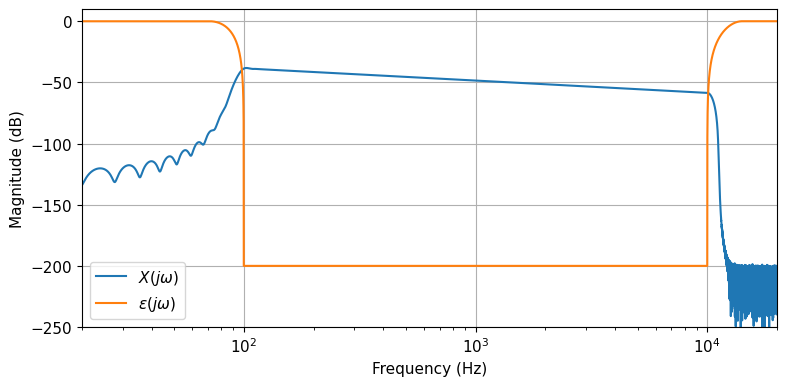

In [15]:
f_min = 100
f_max = 10000

#pytta.classes.signal._make_pk_spectra
data = pytta.classes.signal._make_pk_spectra(xt.freqSignal)
outputFreqSignal = pytta.classes.signal._make_pk_spectra(yt.freqSignal)

freqVector = xt.freqVector
b = data * 0 + 10**(-200/20) # inside signal freq range
a = data * 0 + 1 # outside signal freq range
eps = ht._crossfade_spectruns(a, b, [f_min/np.sqrt(2), f_min], freqVector)
eps = ht._crossfade_spectruns(eps, a, [f_max, f_max*np.sqrt(2)], freqVector)

#eps = eps * float(np.max(np.abs(data)))**2 * 1/2

plt.figure(figsize = (8, 4))
plt.semilogx(freqVector, 20*np.log10(np.abs(xt.freqSignal)), label = r"$X(j\omega)$")
plt.semilogx(freqVector, 20*np.log10(np.abs(eps)), label = r"$\epsilon(j\omega)$")
plt.legend()

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim((20, 20000))
plt.ylim((-250, 10))
plt.grid()
plt.tight_layout()

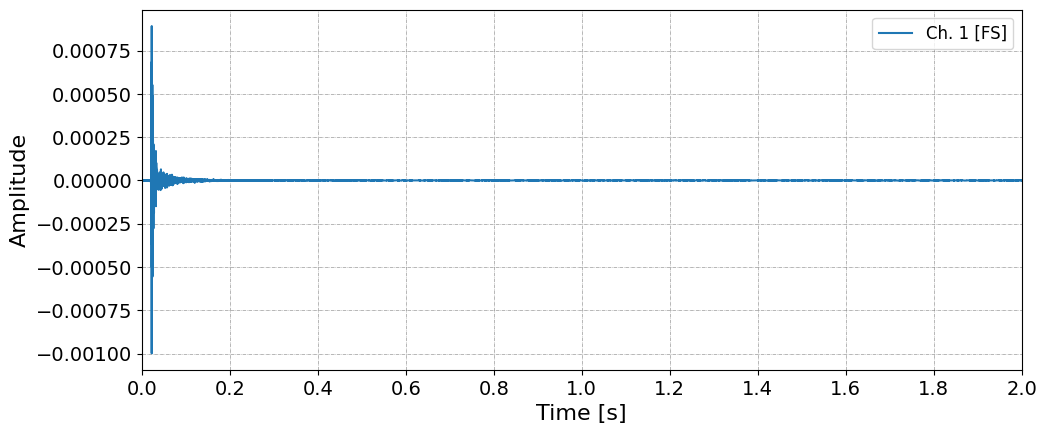

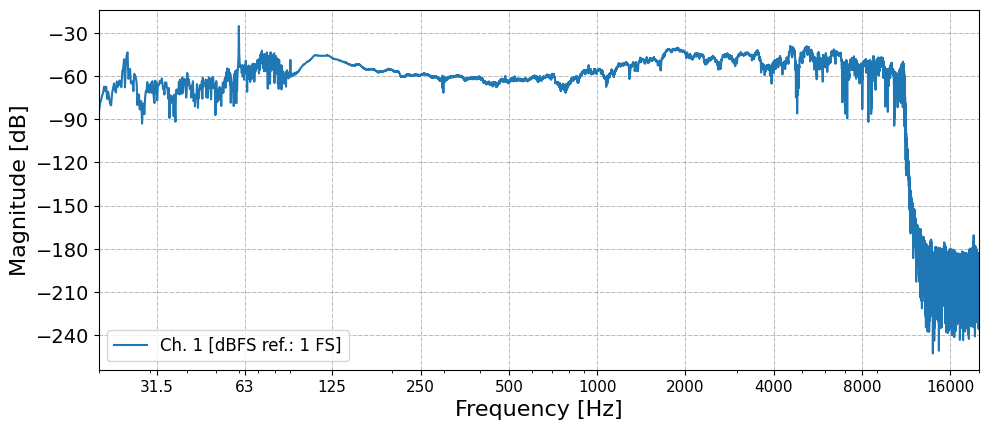

In [16]:
ht.plot_time(xLim = [0, 2], decimalSep = '.');
ht.plot_freq(xLim = [20, 20000], decimalSep = '.');

# plot $h(t)$ in dB (normalized version)

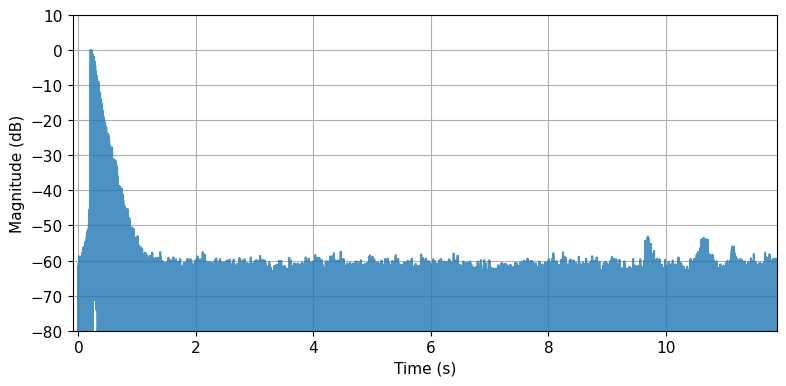

In [28]:
plt.figure(figsize = (8, 4))
plt.plot(ht.IR.timeVector, 20*np.log10(np.abs(ht.IR.timeSignal)/np.amax(np.abs(ht.IR.timeSignal))), alpha = 0.8)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (dB)')
plt.xlim((-0.1, ht.IR.timeVector[-1]))
plt.ylim((-80, 10))
plt.grid()
plt.tight_layout()
#ht.plot_time_dB(xLim = (0.18, 1), yLim = [-120, -60]);

# Room acoustics analysis

This part still need some work. 

- First we crop the IR to remove the non-linear part

In [29]:
ht.IR.crop(startTime = 0, endTime = 2)

# Room IR analysis

Now, we pass the IR to the RoomAnalysis class and it will filter the IR in fractional octave bands, compute the Energy Decay Curves and some room acoustical parameters.

In [30]:
RT = pytta.RoomAnalysis(ht, nthOct=3, minFreq=float(100), maxFreq=float(10000), plotLundeby = False, bypassLundeby = False)

In [34]:
#RT.listEDC

In [31]:
print(RT.fhSignal.timeSignal.shape)
print(RT.fhSignal.timeVector.shape)
print(RT.bands)

(79030, 21)
(79030,)
[  100.   125.   160.   200.   250.   315.   400.   500.   630.   800.
  1000.  1250.  1600.  2000.  2500.  3150.  4000.  5000.  6300.  8000.
 10000.]


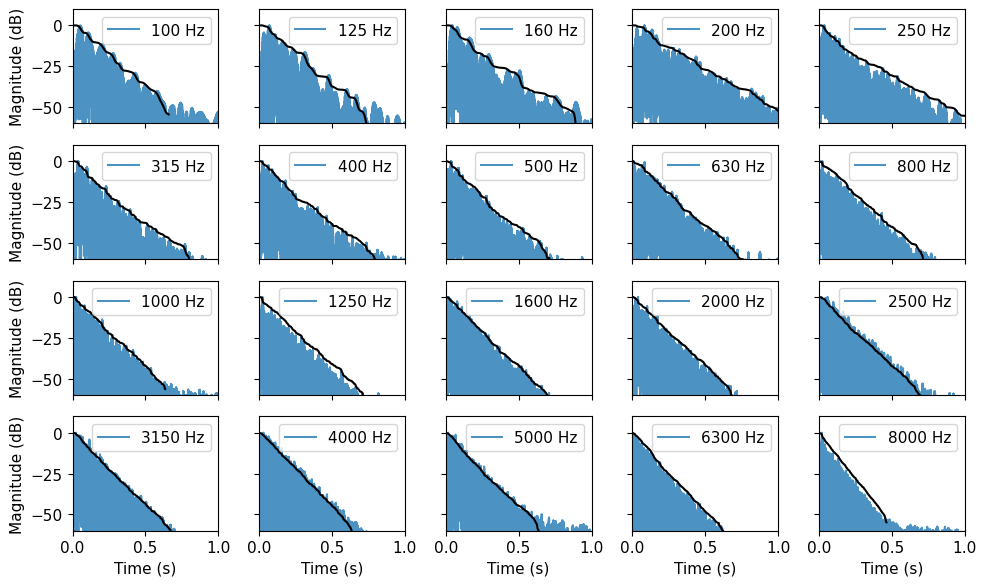

In [32]:
f, ax = plt.subplots(4, 5, figsize = (10, 6), sharex = True, sharey = True)

counter = 0
for row in range(4):
    for col in range(5):
        ht2 = (np.abs(RT.fhSignal.timeSignal[:, counter])/np.amax(np.abs(RT.fhSignal.timeSignal[:, counter])))**2
        ax[row, col].plot(RT.fhSignal.timeVector, 10*np.log10(ht2), alpha = 0.8, 
                          label = r'{} Hz'.format(int(RT.bands[counter])))
        ax[row, col].plot(RT.listEDC[counter][1], 10*np.log10(RT.listEDC[counter][0]), 'k')
        ax[row, col].legend()
        ax[row, col].set_xlim((0, 1))
        ax[row, col].set_ylim((-60, 10))
        counter += 1
        ax[3, col].set_xlabel('Time (s)')
    ax[row, 0].set_ylabel('Magnitude (dB)')

plt.tight_layout()

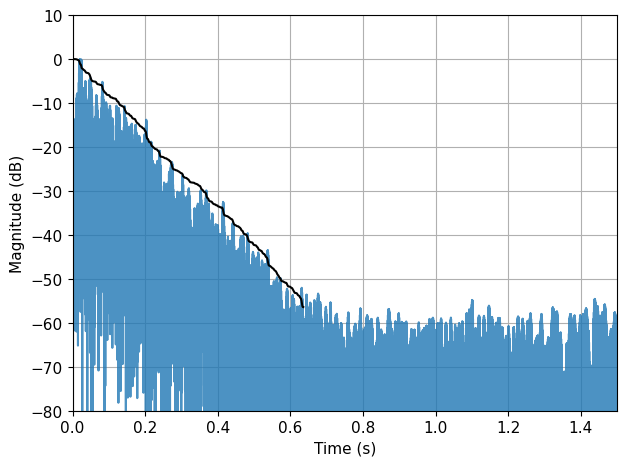

In [33]:
index = 10
ht2 = (np.abs(RT.fhSignal.timeSignal[:, index])/np.amax(np.abs(RT.fhSignal.timeSignal[:, index])))**2

plt.figure()
plt.plot(RT.fhSignal.timeVector, 10*np.log10(ht2), alpha = 0.8)
plt.plot(RT.listEDC[index][1], 10*np.log10(RT.listEDC[index][0]), 'k')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (dB)')
plt.xlim((0, 1.5))
plt.ylim((-80, 10))
plt.grid()
plt.tight_layout()

# $T_{30}$, EDT, $C_{80}$, $T_s$

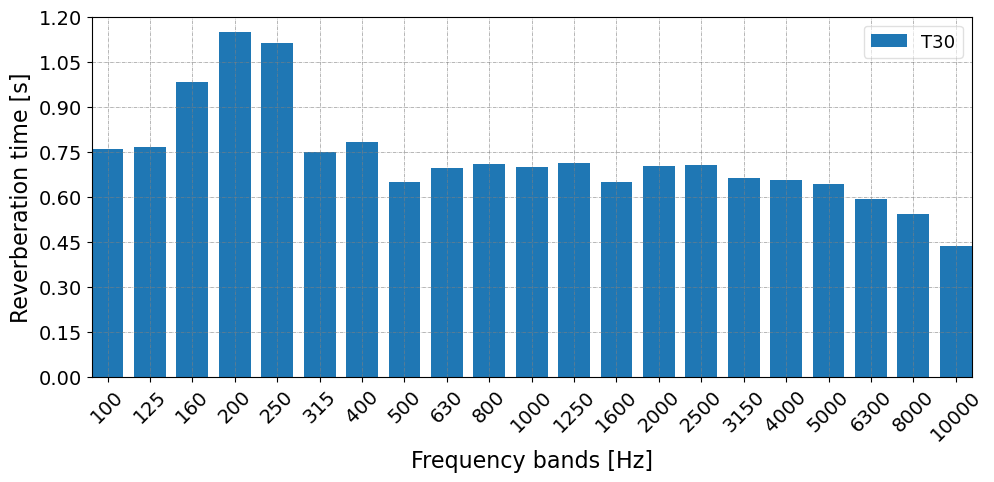

In [34]:
RT.plot_T30(yLim = (0, 1.2), decimalSep = '.');

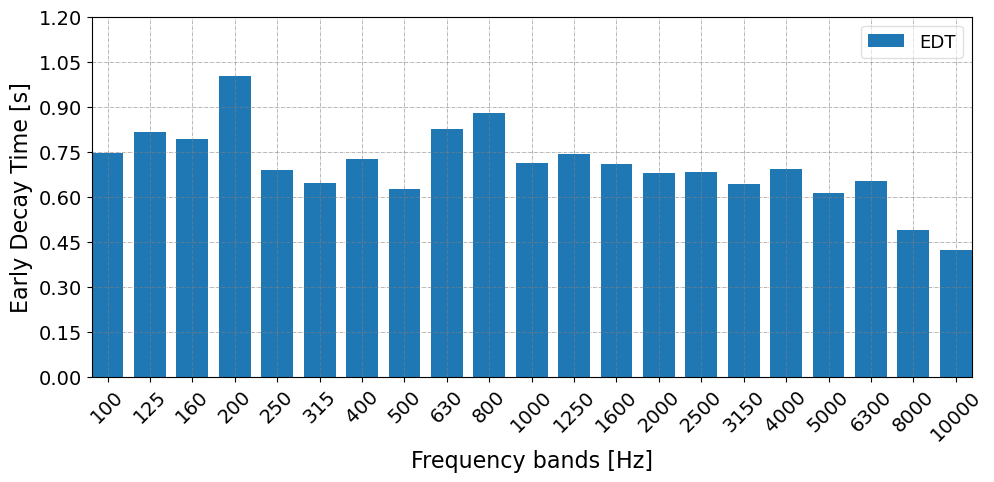

In [35]:
RT.plot_EDT(yLim = (0, 1.2), decimalSep = '.');

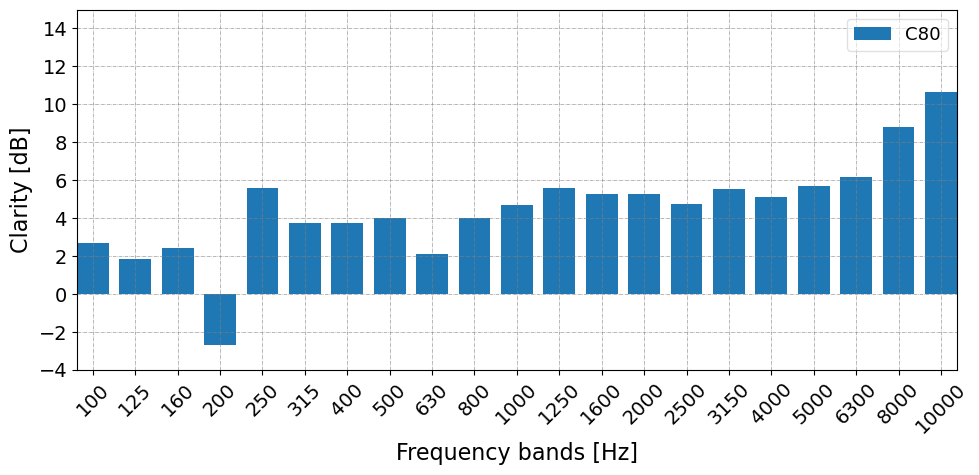

In [36]:
RT.plot_C80(yLim = (-4, 15), decimalSep = '.');

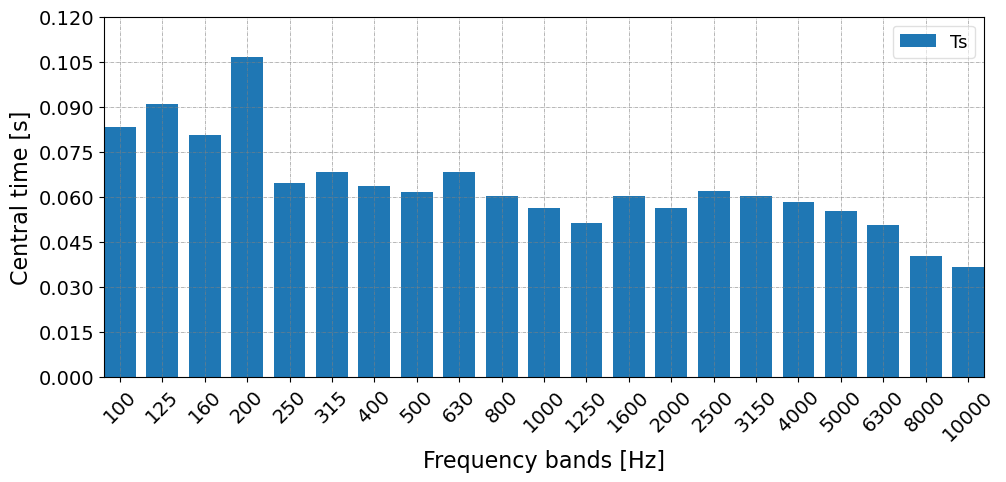

In [37]:
RT.plot_Ts(yLim = (0, 0.12), decimalSep = '.');

# Recording

Let us demonstrate a recording with Pytta.

In [38]:
pytta_rec = pytta.generate.measurement('rec', samplingRate = fs, device = device, 
                                       inChannels=[1], lengthDomain = 'time', timeLength = 10)

In [39]:
rec = pytta_rec.run()

max input level (excitation) on channel [1]: -41.68 dBFS - ref.: 1 [FS]


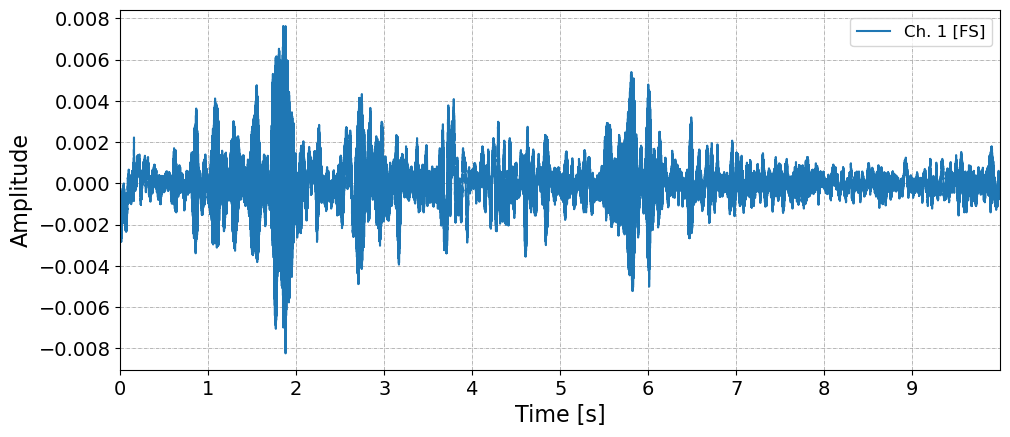

In [41]:
rec.plot_time(decimalSep = '.');

[<Figure size 1000x500 with 2 Axes>]

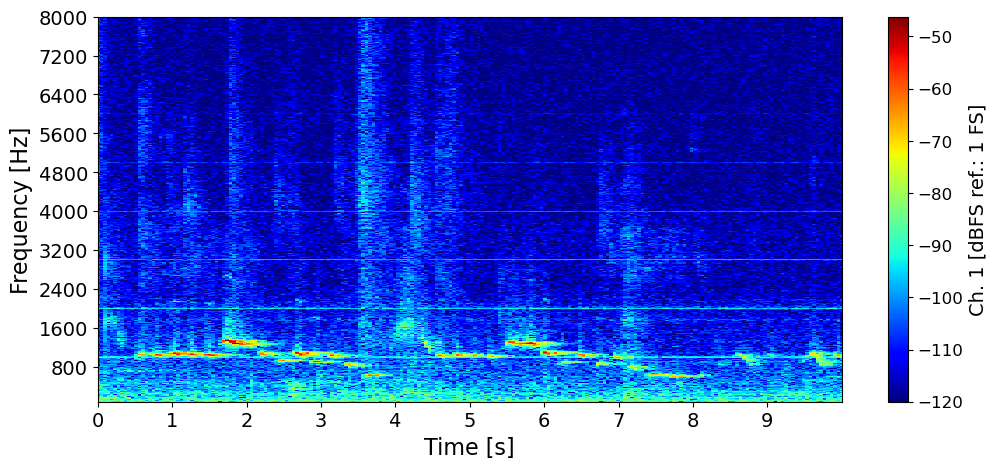

In [42]:
rec.plot_spectrogram(winSize = 4096, overlap = 0.5, yLim = [80, 8000])

# Listen with headphones

In [43]:
rec.play(device = 10)